Master in Cyber Security: CNA EXAM - Complex Network Analysis {-}
====================================

Francesco Fornasieri, Davide Continanza, Alessandro Paolillo,  2023 {-}
----------------

# Analysis of Complex Networks with python and igraph {-}
#stuff



# Part 0. Import useful stuff {-}

In [14]:
# interactive plots in Jupyter, used to show plots inline in the notebook
%matplotlib inline

# The igraph library
from igraph import *

# Numpy for enhanced math array management
import numpy as np
import pandas as pd
# statistical tools (we only use ECDF)
from statsmodels.distributions.empirical_distribution import ECDF

# Mathematical plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# use to control whether to show the entire cell output or only the last_expr (default)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# to generate random numbers
from random import *

# to fit power law distributions
from powerlaw import *

# Part 1. Reading graphs from files / Writing graphs to files

In [46]:
#fg = read("../dataset/soc-redditHyperlinks-body.tsv", format = "csv", directed = True)
df = pd.read_table('../dataset/soc-redditHyperlinks-body.tsv')
df.head()
g = Graph.DataFrame(df, directed=True, use_vids=False)
#Gm = Graph.TupleList(df, directed = True)
#g = Graph.Read_Ncol("../dataset/soc-redditHyperlinks-body.tsv", directed=True)
#print (read())

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."


__Notes__

  - $\texttt{ncol}$ is a simple format of the kind $\texttt{n1 n2 <weight>}$
    - the third column is optional, and by default it is considered as the weight of the link, if present
  - $\texttt{directed}$ is $\tt{True}$ by default

### A summary of the graph:

In [47]:
summary(g, verbosity=2, max_rows = 50, edge_list_format = 'edgelist')

IGRAPH DN-- 35776 286561 -- 
+ attr: name (v), LINK_SENTIMENT (e), POST_ID (e), PROPERTIES (e), TIMESTAMP (e)
+ edges (vertex names):
                         edge                     LINK_SENTIMENT   POST_ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              PROPERTIES                                                                                

__Notes__

1. The four initial letters in the first row
      - D/U if the graph is directed/undirected
      - N/- if vertices have/don't have a name (name attribute in the second row, refers to vertices ("v"))
      - W/- if edges are/are not weighted (weight attribute in the second row, refers to edges ("e"))
      - B/- if the graph is/is not bipartite

2. Then
      - the number of nodes
      - the number of edges
  
3. Edgelist format shows the graph one edge per row
      - **id of the edge** in square brackets
      - edge with vertex **names** (not IDs) in the second column
      - attributes of the edge in the following columns
  
4. See the $\tt{GraphSummary}$ [documentation](https://python.igraph.org/en/stable/api/igraph.summary.GraphSummary.html) for more details on how to format the output
      - all parameters of the $\tt{\_\_init()\_\_}$ method can be used as parameters of $\tt{summary()}$

__The undirected version of the graph__

In [4]:
fg_u = read("./facebook.ncol", format = "ncol", directed = False)
summary(fg_u, verbosity = 1, max_rows = 25, edge_list_format = "edgelist")

IGRAPH UNW- 45813 264004 -- 
+ attr: name (v), weight (e)
+ edges (vertex names):
         edge     weight
[0]    2--3           13
[1]    2--79           1
[2]    2--872          1
[3]    2--1043         1
[4]    2--1847         8
[5]    2--3306        11
[6]    2--3372         3
[7]    2--4605         1
[8]    2--5402         4
[9]    2--5875         4
[10]   2--8785        16
[11]   2--10609       25
[12]   2--10998        1
[13]   2--11186        5
[14]   2--12172        3
[15]   2--17766        1
[16]   2--18086        6
[17]   2--18745        1
[18]   2--30579        5
[19]   2--42558        1
[20]   2--3            8
[21]   5--27         163
[22]   5--108          3
[23]   5--129          2
[24]   5--207          5


__Notes__

Note edges with IDs 0 and 20
  - double edge between nodes 2 and 3
  - compare with the directed case
  - **NB**: $\tt{read()}$$ only reads data from the file, it does not interpret whether this represents a directed or undirected graph

### Writing graphs to files
with the $\tt{write()}$ method

In [5]:
write(fg, "./facebook.pajek", format = "pajek")

# Part 2. Connected components, Giant Component & Subgraphs

In [6]:
toy_g = read("./toy_graph_2.ncol", format = "ncol", directed = True)
summary(toy_g, verbosity = 1, edge_list_format = "edgelist")

IGRAPH DNW- 7 9 -- 
+ attr: name (v), weight (e)
+ edges (vertex names):
      edge   weight
[0]   1->2    0.100
[1]   1->3    0.300
[2]   1->4    0.010
[3]   1->5    0.500
[4]   2->5        1
[5]   3->4    0.900
[6]   5->a    0.030
[7]   a->b    0.020
[8]   b->a    0.010


In [7]:
# Check whether the graph is connected or not
toy_g.is_connected(mode = "WEAK")
toy_g.delete_edges(toy_g.get_eid("5","a"))
toy_g.is_connected(mode = "WEAK")

True

False

In [8]:
# Compute the connected components in the graph
#   - "WEAK" does not consider the direction of edges
toy_g_conn_comp = toy_g.connected_components(mode = "WEAK")

# the number of components
len(toy_g_conn_comp)

# the membership of vertices in the components
toy_g_conn_comp.membership

# the sizes of the components
toy_g_conn_comp.sizes()

# the vertex IDs of the first components
toy_g_conn_comp[0]

# the Giant Componet (the biggest components)
toy_g_GC = toy_g_conn_comp.giant()
summary(toy_g_GC, verbosity = 1, edge_list_format = "edgelist")

2

[0, 0, 0, 0, 0, 1, 1]

[5, 2]

[0, 1, 2, 3, 4]

IGRAPH DNW- 5 6 -- 
+ attr: name (v), weight (e)
+ edges (vertex names):
      edge   weight
[0]   1->2    0.100
[1]   1->3    0.300
[2]   1->4    0.010
[3]   1->5    0.500
[4]   2->5        1
[5]   3->4    0.900


### The Giant Component of the Facebook dataset

In [9]:
# weakly connected components means that it is sufficient that nodes are connected via a unidirected path
# strongly connected components means that nodes must be mutually connected via two unidirected paths
fg_cc = fg.connected_components(mode='WEAK')
fb_GC = fg_cc.giant()
summary(fb_GC, verbosity = 1, edge_list_format = "edgelist", max_rows = 20)

# number of vertices and edges in the original graph
fg.vcount()
fg.ecount()

# number of clusters
len(fg_cc)

# sizes (sorted, first 20 elements)
sorted(fg_cc.sizes(), reverse=True)[0:19]

IGRAPH DNW- 43953 262631 -- 
+ attr: name (v), weight (e)
+ edges (vertex names):
         edge     weight
[0]    2->3           13
[1]    2->79           1
[2]    2->872          1
[3]    2->1043         1
[4]    2->1847         8
[5]    2->3306        11
[6]    2->3372         3
[7]    2->4605         1
[8]    2->5402         4
[9]    2->5875         4
[10]   2->8785        16
[11]   2->10609       25
[12]   2->10998        1
[13]   2->11186        5
[14]   2->12172        3
[15]   2->17766        1
[16]   2->18086        6
[17]   2->18745        1
[18]   2->30579        5
[19]   2->42558        1


45813

264004

842

[43953, 6, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

### Induced subgraph

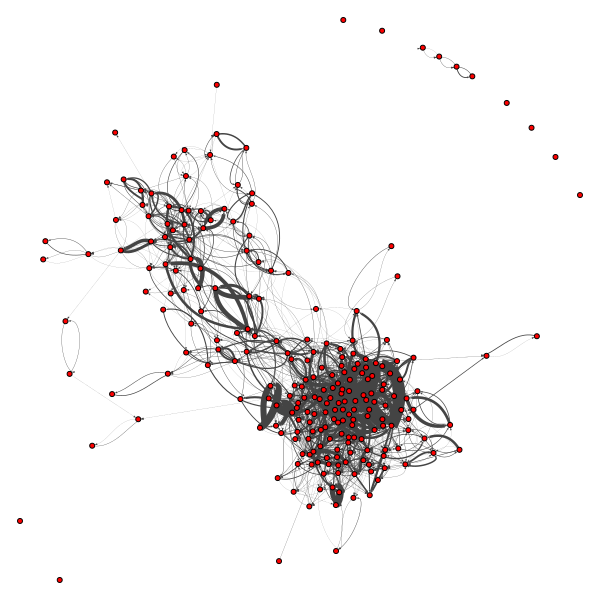

In [10]:
# Select only nodes with degree > 100 from the FB Giant Component
vs = fb_GC.vs.select(_degree_gt = 100)

# "Induced" subgraph: graph composed by
# - a set of vertices (from the original graph)
# - only the edges connecting those vertices (in the original subgraph)
fb_g_sub = fb_GC.induced_subgraph(vs)

try:
    del visual_style
    visual_style = {}
except NameError:
    visual_style = {}
    
visual_style["bbox"] = (600,600)
visual_style["label"] = []
visual_style["layout"] = fb_g_sub.layout_fruchterman_reingold()
visual_style["vertex_size"] = 5
visual_style["vertex_color"] = 'red'
visual_style["vertex_shape"] = 'circle'
visual_style["edge_arrow_size"] = 0.2
visual_style["edge_width"] = np.array(fb_g_sub.es["weight"])/10

plot(fb_g_sub, **visual_style)

__Notes__

- what you see is not a connected component of the __original__ Facebook graph
    - the subgraph has taken all vertices in the GC, whose degree is higher than 100, and the link __between__ these nodes
    - therefore, the selected vertices usually have many more edges in the GC (towards vertices with degree <= 100) which one does not see in the plot

# Part 3. Plotting graphs
This is based on the igraph $\tt{plot()}$ method, which is built on the $\tt{Cairo}$ package (and specifically on the $\tt{pycairo}$ bindings between Cairo and Python).

The layout of the graph (i.e., the __coordinates__) of the vertices, must be computed first, with the $\tt{layout()}$ functions.

- many algorithms can be used to properly compute coordinates, based essentially on the edges and their weights.

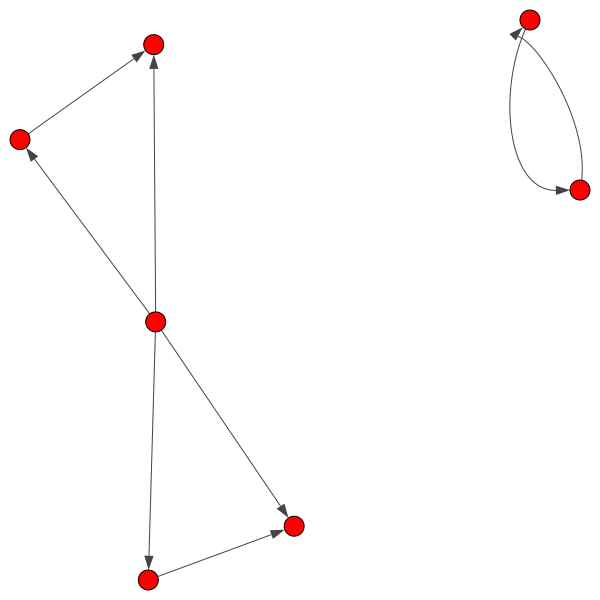

In [11]:
# Compute the layout, using one of the possible methods (Fructherman-Reingold)
layout = toy_g.layout_fruchterman_reingold()

# Plot the graph
plot(toy_g, layout = layout)

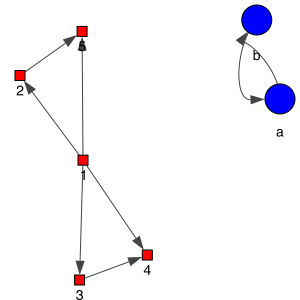

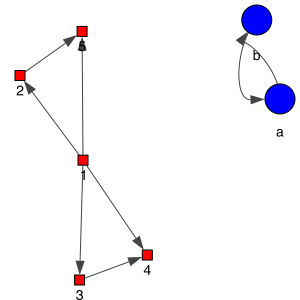

In [12]:
# Beautyfying the the plot with some visual style attributes
# - define a dictionary for setting the required options
# - use the dictionary as the plot parameter
# - see http://igraph.org/python/doc/tutorial/tutorial.html for the set of possible options

colors = ['red', 'blue']
shapes = ['rectangle', 'circle']
sizes = [10,30]

try:
    del visual_style
    visual_style = {}
except NameError:
    visual_style = {}

visual_style["bbox"] = (300,300)
visual_style["vertex_label"] = toy_g.vs["name"]
visual_style["vertex_label_dist"] = 2
visual_style["vertex_size"] = [sizes[toy_g_conn_comp.membership[i]] for i in range(toy_g.vcount())]
visual_style["vertex_color"] = [colors[toy_g_conn_comp.membership[i]] for i in range(toy_g.vcount())]
visual_style["vertex_shape"] = [shapes[toy_g_conn_comp.membership[i]] for i in range(toy_g.vcount())]
visual_style["layout"] = layout

plot(toy_g, **visual_style)
plot(toy_g, "toy_g_plot.pdf", **visual_style)

## Plotting the components
When using $\tt{plot()}$ with a VertexClustering object

- vertices belonging to different components are automatically colored differently
    - if visual style is provided, its values are used instead of default
- the $\tt{mark\_group}$ parameter can be used to highlight groups with shapes
    - $\tt{True}$ for default colors

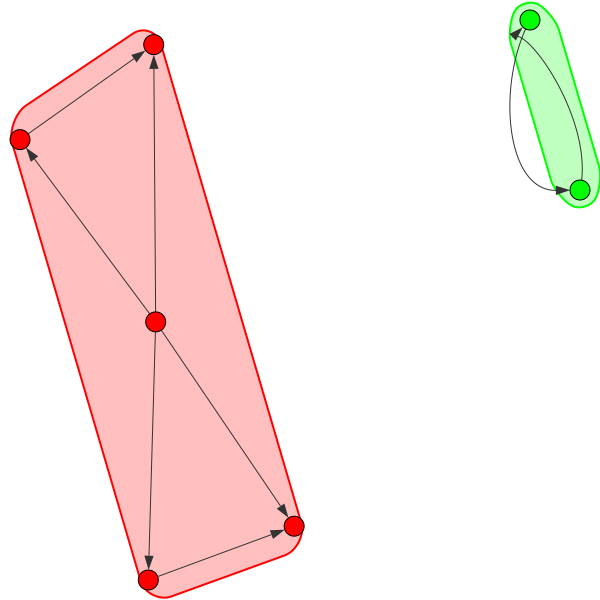

In [13]:
try:
    del visual_style
    visual_style = {}
except NameError:
    visual_style = {}
plot(toy_g_conn_comp, layout=layout, mark_groups = True)

# Part 4. Degree Analysis

In [14]:
# degree() method
# - mode = "ALL" to consider the undirected graph
fb_deg = fb_GC.degree(mode = "all")
fb_deg[0:19]

# the maximum degree, and the ID of the node with maximum degree
max(fb_deg)
id_max = np.argmax(fb_deg)
id_max

# the set of neighbours of the node with max degree
# - NB: in case of bidirectional links, the same neighbour is counted twice if mode = 'all'
nei = fb_GC.neighbors(id_max, mode="all")
len(nei)

# the set of nodes reachable from id_max with AT MOST 1 jump
neighbours = fb_GC.neighborhood(id_max, order = 1, mode="all")
neighbours[0:19]

# the number of such nodes
# - NB: it also includes the node id_max itself (which is reachable with 0 jumps)
# - thus, the number of nodes reachable with one jump is this - 1
len(neighbours)
fb_GC.neighborhood_size(id_max, order = 1, mode="all")

[34, 2, 15, 18, 34, 41, 40, 34, 39, 90, 35, 48, 53, 5, 27, 21, 17, 28, 20]

314

2720

314

[2720,
 7,
 28,
 221,
 228,
 317,
 359,
 459,
 701,
 819,
 1094,
 1096,
 1514,
 1613,
 1698,
 1703,
 1977,
 2264,
 2299]

224

224

__Note__

Why is the output of $\tt{neighbourhood\_size()}$ different from the length of $\tt{nei}$?

- consider that we used a __directed__ graph, and think what does it means in terms of degree and neighbours

Let's redo the same on the equivalent __undirected__ graph

In [15]:
# take the undirected version of the Giant Component 
# combine_edges tells what to do with the weights (default, lost attribute; here: sum values)
fb_GC_u = fb_GC.as_undirected(combine_edges = "sum")

# Note the lower number of edges with respect to the directed version.
# This is because igraph automatically simplifies the graph (i.e., merges edges between the same nodes)
# to do so manually on a multi-edge graph: g.simplify()
# to check if the graph is simple or not: g.is_simple()
summary(fb_GC_u, verbosity = 1, edge_list_format = "edgelist", max_rows = 25)

# the maximum degree, and the ID of the node with maximum degree
fb_deg_u = fb_GC_u.degree()
max(fb_deg_u)
id_max_u = np.argmax(fb_deg_u)
id_max_u

# the set of neighbours of the node with max degree
nei_u = fb_GC_u.neighbors(id_max_u)
len(nei_u)

# the set of nodes reachable from id_max with AT MOST 1 jump
neighbours = fb_GC_u.neighborhood(id_max, order = 1, mode="all")
neighbours[0:19]

# the number of such nodes
# - NB: it also includes the node id_max itself (which is reachable with 0 jumps)
# - thus, the number of nodes reachable with one jump is this - 1
len(neighbours)
fb_GC_u.neighborhood_size(id_max, order = 1, mode="all")

IGRAPH UNW- 43953 182384 -- 
+ attr: name (v), weight (e)
+ edges (vertex names):
           edge       weight
[0]    2--3               21
[1]    2--79               1
[2]    2--872              1
[3]    2--1043             1
[4]    2--1847            15
[5]    2--3306            11
[6]    2--3372             4
[7]    2--4605             1
[8]    79--4605            2
[9]    2--5402             9
[10]   3306--5402          4
[11]   2--5875             4
[12]   2--8785            26
[13]   2--10609           42
[14]   872--10609         26
[15]   8785--10609        56
[16]   2--10998            1
[17]   8785--10998         1
[18]   2--11186            7
[19]   5875--11186         8
[20]   8785--11186        40
[21]   10609--11186       24
[22]   2--12172            5
[23]   8785--12172         4
[24]   10609--12172      232


223

2720

223

[2720,
 7,
 28,
 221,
 228,
 317,
 359,
 459,
 701,
 819,
 1094,
 1096,
 1514,
 1613,
 1698,
 1703,
 1977,
 2264,
 2299]

224

224

### Degree density and CCDF

One way to visualise the density of the degree is through a histogram

- discrete approximation of the density function
- bins = set of intervals for the random variable
- value in each bin = # of samples, absolute or normalised, which fall in the bin
    - i.e., the probability that the random variable takes values in the bin
    
igraph includes a method to compute the histogram of the degree distribution

- $\tt{degree\_distribution()}$

But we use Numpy/Matplotlib methods, which are more flexible

- Numpy: method $\tt{np.histogram()}$ computes the histogram of a set of values
- Matplotlib: method $\tt{plt.hist()}$ computes the histogram (via Numpy), and plots the result

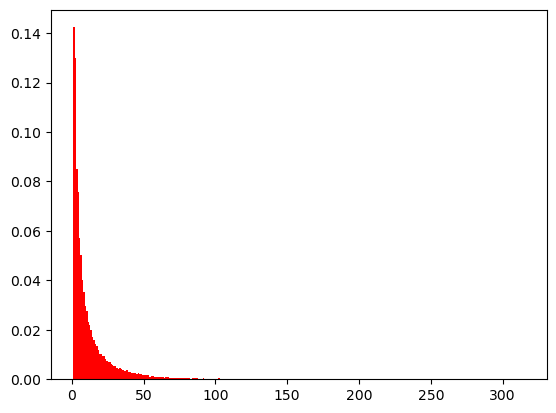

In [16]:
dd_h, dd_h_bins, _ = plt.hist(fb_deg, bins=range(1,max(fb_deg)+2), density=True, color = 'red')

__Notes__

- Return values
    - the values of each bin ($\tt{dd\_h}$)
    - the extremes of the bins ($\tt{dd\_h\_bins}$)
        - __NB__: the number of the extremes is always the number of bins + 1!!!
    - we discard the third return value (variable $\tt{\_}$)

- Parameters
    - $\tt{fb\_deg}$ is the set of values for which the histogram is computed
    - $\tt{bins}$ is a list with the extremes of the bins
        - __NB__: $\tt{max(fb\_deg)+2}$ is because range excludes the second extreme, and the last bin represents the probability of degrees >= $\tt{max(fb\_deg)}$
    - $\tt{density}$ tells whether to normalise the values of bins to 1

In [17]:
# how do the histogram and bins look like
dd_h[0:19]
dd_h_bins[0:19]

array([0.14235661, 0.13009351, 0.0851364 , 0.07569449, 0.0569927 ,
       0.05014447, 0.04022479, 0.03510568, 0.02948604, 0.02762041,
       0.02300184, 0.02200077, 0.02006689, 0.01722294, 0.01581235,
       0.01431074, 0.01362819, 0.01196733, 0.01003344])

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19.])

Text(0.5, 0, 'd')

Text(0, 0.5, 'P(Degree = d)')

Text(0.5, 1.0, 'Degree density on a log-log scale')

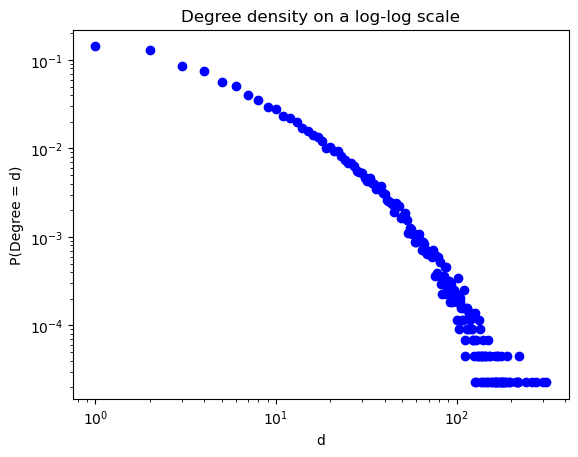

In [18]:
# Degree density on a loglog scale
plt.loglog(dd_h_bins[:-1], dd_h, 'bo')
plt.xlabel("d")
plt.ylabel("P(Degree = d)")
plt.title("Degree density on a log-log scale")

(0.0, 100.0, 0.0, 1.0)

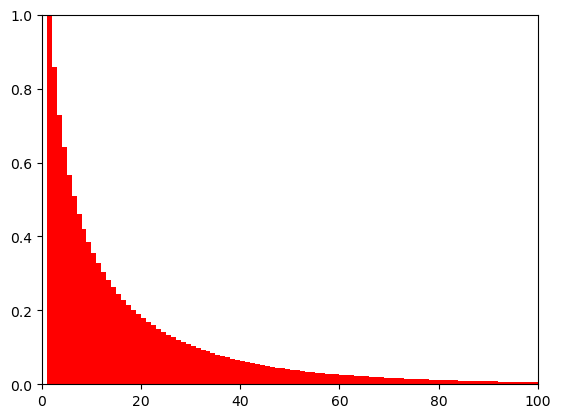

In [19]:
# Compute the CCDF - we can use 2 ways
# 1. use the histogram functions with parameter cumulative=-1 gives the CCDF
dd_h, dd_h_bins, _ = plt.hist(fb_deg, bins=range(1,max(fb_deg)+2), density = True, color = 'red', cumulative = -1)
plt.axis([0,100,0,1])

Text(0.5, 0, '$d$')

Text(0, 0.5, '$P(D>d)$')

Text(0.5, 1.0, 'Degree CCDF in a lin-lin scale')

Text(0.5, 0, '$d$')

Text(0, 0.5, '$P(D>d)$')

Text(0.5, 1.0, 'Degree CCDF in a log-log scale')

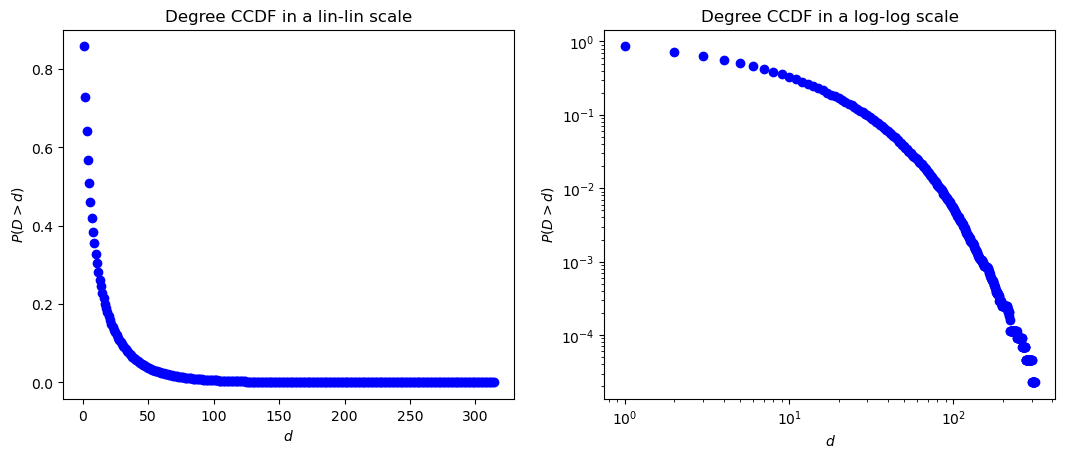

In [20]:
# 2. More general: use the ECDF function of statsmodels.distributions.empirical_distribution
# ECDF(dataset) returns a the empirical CDF computed from the dataset, which can be used as a FUNCTION
# - i.e., it is possible to call ECDF(x) for any x, irrespective of the set of data from which the ECDF is derived
deg_cdf = ECDF(fb_deg)

# scale the fig size twice in length
default_sizes = plt.rcParams["figure.figsize"]
fig_sizes = (2*default_sizes[0], default_sizes[1])

# generate a figure with 2 subplots, organised in 1 row and 2 columns
# ax1 and ax2 ("axes") are used to access the individual plots
# NB: in case of more rows, axes must be specified as list of lists, e.g., for 2x2 ((ax1,ax2),(ax3,ax4))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = fig_sizes)

# plot the CCDF in lin-lin and log-log scales
# see http://matplotlib.org/api/axes_api.html for the API of the Axis class
# see http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot or the Axes.plot() documentation
# for the parameters of the plot method
degs = np.arange(1,max(fb_deg)+1)

ax1.plot(degs, 1-deg_cdf(degs), 'bo')
ax1.set_xlabel("$d$")
ax1.set_ylabel("$P(D>d)$")
ax1.set_title("Degree CCDF in a lin-lin scale")

ax2.loglog(degs, 1-deg_cdf(degs), 'bo')
ax2.set_xlabel("$d$")
ax2.set_ylabel("$P(D>d)$")
ax2.set_title("Degree CCDF in a log-log scale")

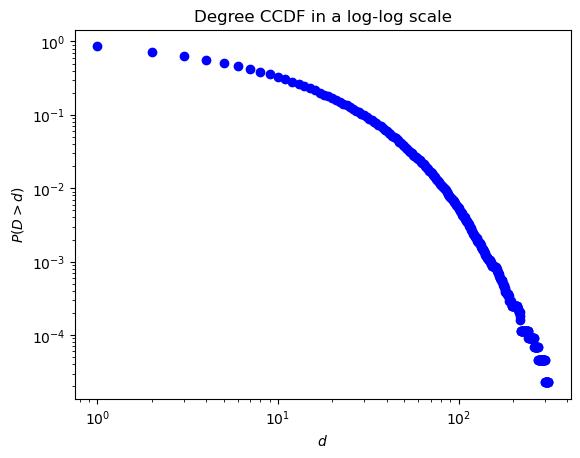

In [21]:
_ = plt.loglog(degs, 1-deg_cdf(degs), 'bo')
_ = plt.xlabel("$d$")
_ = plt.ylabel("$P(D>d)$")
_ = plt.title("Degree CCDF in a log-log scale")

# Part 5. Equivalent graphs and fitting

## Random graphs

According to the Erdős–Rényi model, a random graph is constructed by connecting nodes randomly with probability $p$.
We build an Erdős–Rényi model equivalent to the Facebook graph

- equivalence means the same number of nodes, and the same average degree
    - thus, $p = \frac{\langle k \rangle}{N}$

43939

43953

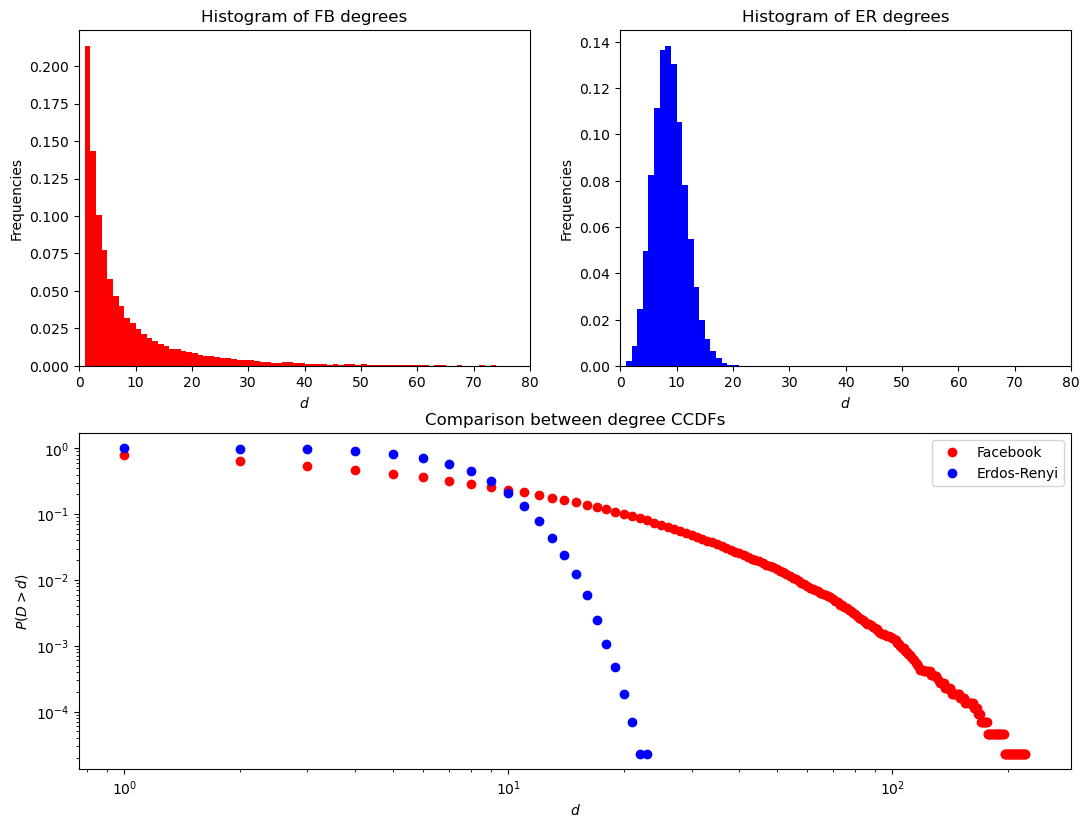

In [22]:
# Now we compare the degree distributions for the complete fb Giant Component
er_p_GC = mean(fb_GC_u.degree())/fb_GC_u.vcount()
er_fb_all = Graph.Erdos_Renyi(fb_GC_u.vcount(), er_p_GC)

# take only the Giant Component
er_fb = er_fb_all.connected_components(mode = "WEAK").giant()
er_fb.vcount()
fb_GC_u.vcount()

# we use GridSpecs for a finer control of the plot positioning
fig_sizes = (fig_sizes[0], 2*default_sizes[1])
f = plt.figure(figsize = fig_sizes)

# create a 2x2 Grid Specification
gs = gridspec.GridSpec(2, 2)

# add subplots to the figure, using the GridSpec gs
# position [0,0] (upper-left corner)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
# the third plot spans the entire second row
ax3 = plt.subplot(gs[1,:])

# compute and plot the histogram of FB degrees
d_fb = fb_GC_u.degree()
_,_,_ = ax1.hist(d_fb, bins=range(1,max(d_fb)+2), density = True, color = 'red')
_ = ax1.set_xlim(0,80)
_ = ax1.set_xlabel("$d$")
_ = ax1.set_ylabel("Frequencies")
_ = ax1.set_title("Histogram of FB degrees")

# compute and plot the histogram of ER degrees
d_er = er_fb.degree()
_,_,_ = ax2.hist(d_er, bins=range(1,max(d_er)+2), density = True, color = 'blue')
_ = ax2.set_xlim(0,80)
_ = ax2.set_xlabel("$d$")
_ = ax2.set_ylabel("Frequencies")
_ = ax2.set_title("Histogram of ER degrees")

# compute and plot the degree CCDFs
fb_ecdf = ECDF(d_fb)
er_ecdf = ECDF(d_er)
x = np.arange(1,max(d_fb)+1)
_ = ax3.loglog(x, 1-fb_ecdf(x), 'ro', label = 'Facebook')
x = np.arange(1,max(d_er)+1)
_ = ax3.loglog(x, 1-er_ecdf(x), 'bo', label = 'Erdos-Renyi')
_ = ax3.set_xlabel("$d$")
_ = ax3.set_ylabel("$P(D>d)$")
_ = ax3.set_title("Comparison between degree CCDFs")
_ = ax3.legend(numpoints = 1)

## Power Laws

In [23]:
# First, we find the best power law fit for the degree distribution
# with a fixed minimum value xmin (minimum degree for which the fitting is computed)
# - see the plot of the CCDFs for understanding how fitting depends on xmin
xmin = 10
fit_pl = Fit(fb_GC_u.degree(), xmin = xmin)
# by computing automatically the "best" xmin value
fit_pl_auto = Fit(fb_GC_u.degree())

exp_pl_auto = fit_pl_auto.alpha
xmin_auto = fit_pl_auto.xmin
exp_pl = fit_pl.alpha
print ("PL exponents: (xmin=%d) %.2f; (auto xmin=%.2f) %.2f" % (xmin, exp_pl, xmin_auto, exp_pl_auto))

# compute the number of nodes and edges of the FB graph to generate the equivalent static Power Law graph
N = fb_GC_u.vcount()
M = fb_GC_u.ecount()

# Equivalent graph for the fitting with fixed xmin
pl_fb_all = Graph.Static_Power_Law(N, M, exp_pl)
# the graph could not be connected, so keep the GC only
pl_fb = pl_fb_all.connected_components(mode = "WEAK").giant()

# Equivalent graph for the fitting with automatic xmin
pl_fb_auto_all = Graph.Static_Power_Law(N, M, exp_pl_auto)
pl_fb_auto = pl_fb_auto_all.connected_components(mode = "WEAK").giant()

Calculating best minimal value for power law fit
PL exponents: (xmin=10) 2.54; (auto xmin=101.00) 6.75


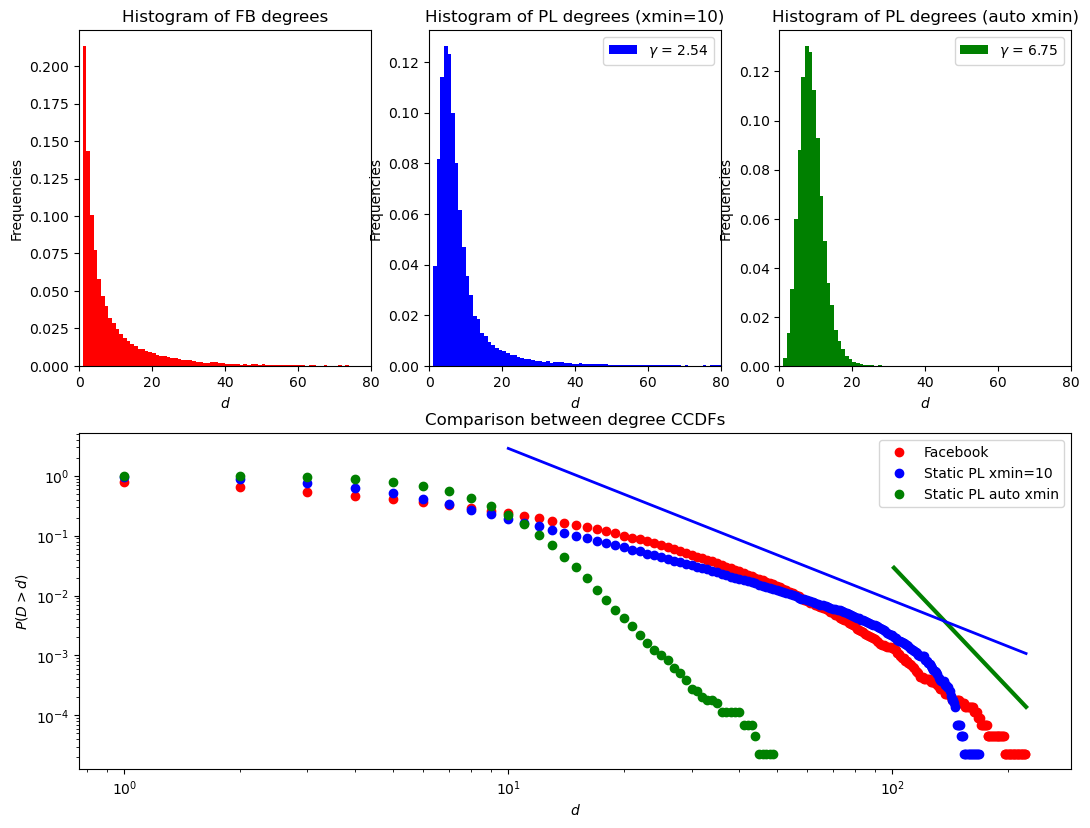

In [24]:
# Now we compare the degree distributions for the complete fb Giant Component
# we use GridSpecs for a finer control of the plot positioning
fig_sizes = (fig_sizes[0], 2*default_sizes[1])
f = plt.figure(figsize = fig_sizes)

# create a 2x3 Grid Specification
gs = gridspec.GridSpec(2, 3)

# add subplots to the figure, using the GridSpec gs
# position [0,0] (upper-left corner)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
# the fourth plot spans the entire second row
ax4 = plt.subplot(gs[1,:])

# compute and plot the histogram of FB degrees
d_fb = fb_GC_u.degree()
_,_,_ = ax1.hist(d_fb, bins=range(1,max(d_fb)+2), density = True, color = 'red')
_ = ax1.set_xlim(0,80)
_ = ax1.set_xlabel("$d$")
_ = ax1.set_ylabel("Frequencies")
_ = ax1.set_title("Histogram of FB degrees")

# compute and plot the histogram of Static Power Law degrees with set xmin
d_pl = pl_fb.degree()
_,_,_ = ax2.hist(d_pl, bins=range(1,max(d_pl)+2), density = True, color = 'blue', label = "$\gamma$ = %.2f" % exp_pl)
_ = ax2.set_xlim(0,80)
_ = ax2.set_xlabel("$d$")
_ = ax2.set_ylabel("Frequencies")
_ = ax2.set_title("Histogram of PL degrees (xmin=%d)" % xmin)
_ = ax2.legend()

# compute and plot the histogram of Static Power law degrees with auto xmin
d_pl_auto = pl_fb_auto.degree()
_,_,_ = ax3.hist(d_pl_auto, bins=range(1,max(d_pl_auto)+2), density = True, color = 'green', label = "$\gamma$ = %.2f" % exp_pl_auto)
_ = ax3.set_xlim(0,80)
_ = ax3.set_xlabel("$d$")
_ = ax3.set_ylabel("Frequencies")
_ = ax3.set_title("Histogram of PL degrees (auto xmin)")
_ = ax3.legend()

# compute and plot the degree CCDFs
fb_ecdf = ECDF(d_fb)
pl_ecdf = ECDF(d_pl)
pl_auto_ecdf = ECDF(d_pl_auto)
x = np.arange(1,max(d_fb)+1)
_ = ax4.loglog(x, 1-fb_ecdf(x), 'ro', label = 'Facebook')
x = np.arange(1,max(d_pl)+1)
_ = ax4.loglog(x, 1-pl_ecdf(x), 'bo', label = 'Static PL xmin=%d' % xmin)
x = np.arange(1,max(d_pl_auto)+1)
_ = ax4.loglog(x, 1-pl_auto_ecdf(x), 'go', label = 'Static PL auto xmin')
_ = ax4.set_xlabel("$d$")
_ = ax4.set_ylabel("$P(D>d)$")
_ = ax4.set_title("Comparison between degree CCDFs")
_ = ax4.legend(numpoints = 1)

# for reference, plot the power law functions corresponding to the fitting with fixed and automatic xmin
x1 = np.arange(xmin_auto, max(d_fb)+1)
_ = ax4.loglog(x1, 1000000000000 * x1**(-exp_pl_auto), 'g-', linewidth = 3)
x1 = np.arange(xmin, max(d_fb)+1)
_ = ax4.loglog(x1, 1000 * x1**(-exp_pl), 'b-', linewidth = 2)

# Part 6. Assortativity, clustering, centrality, path length, communities

## Assortativity

0.21597845991008502

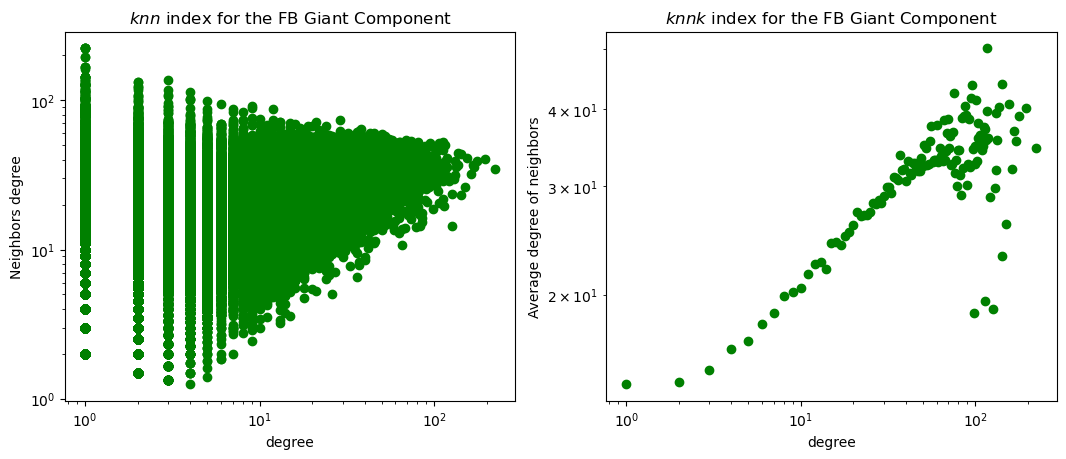

In [25]:
# The global assortativity coefficient - we will need the undirected version of the graph from now on
fb_GC_u.assortativity_degree()

# The knn data. Two lists are returned
# - the list of average degrees for each node (knn)
# - the list of average degrees for each degree (knnk)
fb_knn, fb_knnk = fb_GC_u.knn()

_ = fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (2*default_sizes[0], default_sizes[1]))
_ = ax1.loglog(fb_GC_u.degree(), fb_knn, 'go')
_ = ax1.set_xlabel("degree")
_ = ax1.set_ylabel("Neighbors degree")
_ = ax1.set_title("$knn$ index for the FB Giant Component")

_ = ax2.loglog(range(1,max(fb_GC_u.degree())+1), fb_knnk, 'go')
_ = ax2.set_xlabel("degree")
_ = ax2.set_ylabel("Average degree of neighbors")
_ = ax2.set_title("$knnk$ index for the FB Giant Component")

## Clustering

In [26]:
# global transitivity (C1)
# as_undirected(), otherwise results would be wrong
fb_GC_u.transitivity_undirected()

# average local transitivity (C2)
# mode = 0 means that nodes with less than two neighbours will have zero transitivity
fb_GC_u.transitivity_avglocal_undirected(mode="zero")

# local transitivity for all vertices
local_trans = fb_GC_u.transitivity_local_undirected(mode="zero")
local_trans[0:19]
mean(local_trans)

0.08509450365234017

0.114947594862054

[0.10671936758893281,
 0.0,
 0.03636363636363636,
 0.15151515151515152,
 0.02857142857142857,
 0.034188034188034185,
 0.05172413793103448,
 0.03333333333333333,
 0.06342780026990553,
 0.11038961038961038,
 0.07899159663865546,
 0.09971509971509972,
 0.05376344086021505,
 0.2,
 0.17543859649122806,
 0.15384615384615385,
 0.12727272727272726,
 0.14705882352941177,
 0.07692307692307693]

0.11494759486205622

## Centrality

In [27]:
# we use a subset of the graph, for computational purposes, i.e., we pick the subgraph of nodes in the GC with degree>60
idx = np.argwhere(np.array(fb_GC_u.degree())>60).flatten()
sub_g = fb_GC_u.induced_subgraph(idx)

# closeness centrality
sub_g.closeness()[0:19]

# betweenness centrality
sub_g.betweenness()[0:19]

# edge betweenness, and edge with the maximum edge betweenness
edge_bet = sub_g.edge_betweenness()
idx_max = np.argmax(edge_bet)
idx_max
edge_bet[idx_max]
sub_g.es[idx_max].tuple

[0.26244343891402716,
 0.34765234765234765,
 0.14566764336542487,
 0.25513196480938416,
 0.21983575489576754,
 0.23625254582484725,
 0.2454160789844852,
 0.27060653188180406,
 0.26047904191616766,
 0.29466553767993225,
 0.32923368022705773,
 0.3543788187372709,
 0.35080645161290325,
 0.3790849673202614,
 0.36554621848739494,
 0.36212278876170656,
 0.2740157480314961,
 0.2820097244732577,
 0.2318454363757495]

[0.0,
 882.6684751040468,
 0.0,
 267.25944130141625,
 61.23928721266182,
 21.714340656816724,
 0.0,
 310.1567218777112,
 517.1451005231831,
 823.5947095395933,
 500.431931420729,
 1520.2733552171578,
 571.8367868636249,
 1066.099362652006,
 823.8630946762646,
 745.7871923189141,
 267.39098080958564,
 517.9167857667121,
 21.94094889191422]

56

1720.0

(44, 47)

## Weighted vs Unweighted path lengths

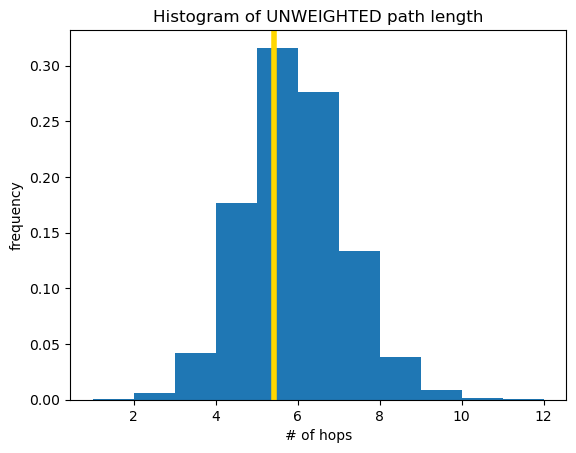

In [28]:
# generated a sample of 100 vertices as source/destinations
src = sample(list(fb_GC_u.vs), 100)
trg = sample(list(fb_GC_u.vs), 100)

# computed the UNWEIGHTED shortest paths
# - result is a matrix, while we need an array for plotting
n_hops_u = fb_GC_u.distances(source = src, target = trg, weights = None)
n_hops_u = np.array(n_hops_u).flatten()

_,_,_ = plt.hist(n_hops_u, bins = range(1,max(n_hops_u)+2), density = True)
_ = plt.axvline(mean(n_hops_u), color = 'gold', linewidth = 4)
_ = plt.xlabel("# of hops")
_ = plt.ylabel("frequency")
_ = plt.title("Histogram of UNWEIGHTED path length")

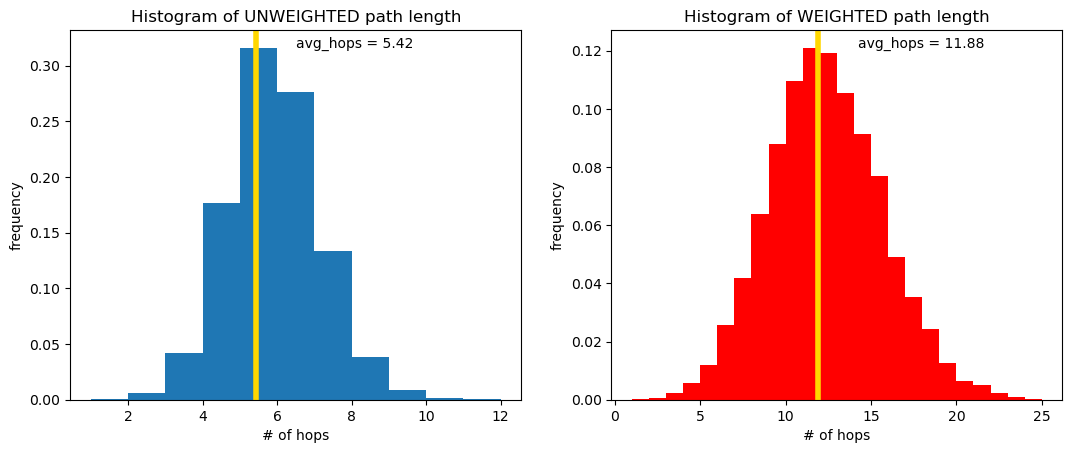

In [29]:
# WEIGHTED SHORTEST PATHS
# - weights in the dataset are the importance of the relationship,
#   while shortest paths assume this is a cost
# - so, use 1/weights as the weights of the shortest path computations
weights = 1/np.array(fb_GC_u.es["weight"])

# fb_GC.distances returns the WEIGHTED NUMBER OF HOPS
# - instead, we need the number of hops on the shortest (weighted) path
# - so, we need to:
#    - compute the shortest weighted paths (method get_shortest_paths)
#    - extract the # of hops
#    - get_shortest_paths() can be used on a SINGLE source vertices at a time
#    - so, we need to cycle over all elements of src,
#      and compute the number of hops towards all target nodes (function n_hops)
def n_hops(s, t, w):
    sps = fb_GC_u.get_shortest_paths(s, t, output = 'epath', weights = w)
    return [len(sps[i]) for i in range(0,len(sps))]

n_hops_w = []
for s in src:
    n_hops_w += n_hops(s, trg, weights)

# prepare for plotting the two distributions of shortest paths lengths
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (2*default_sizes[0], default_sizes[1]))

# plot the density and the average value (as a vertical line) of the unweighted distribution in the first plot
h_values,_,_ = ax1.hist(n_hops_u, bins = range(1,max(n_hops_u)+2), density = True)
mean_u_hops = mean(n_hops_u)
_ = ax1.axvline(mean_u_hops, color = 'gold', linewidth = 4)
_ = ax1.text(1.2*mean_u_hops, max(h_values), "avg_hops = %.2f" % mean_u_hops)
_ = ax1.set_xlabel("# of hops")
_ = ax1.set_ylabel("frequency")
_ = ax1.set_title("Histogram of UNWEIGHTED path length")

# plot the density and the average value (as a vertical line) of the weighted distribution in the second plot
h_values,_,_ = ax2.hist(n_hops_w, bins = range(1,max(n_hops_w)+2), density = True, color = 'red')
mean_w_hops = mean(n_hops_w)
_ = ax2.axvline(mean(n_hops_w), color = 'gold', linewidth = 4)
_ = ax2.text(1.2*mean_w_hops, max(h_values), "avg_hops = %.2f" % mean_w_hops)
_ = ax2.set_xlabel("# of hops")
_ = ax2.set_ylabel("frequency")
_ = ax2.set_title("Histogram of WEIGHTED path length")

## Community detection

10

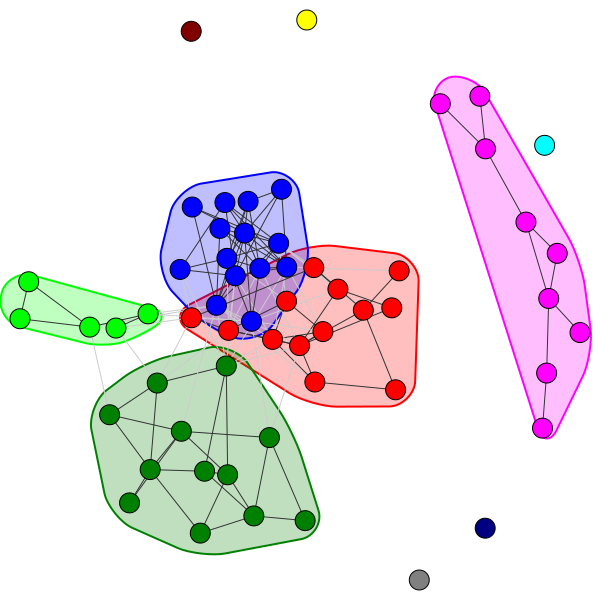

array([  0,   4,   6,  11,  16,  18,  22,  23,  30,  31,  32,  35,  37,
        40,  44,  48,  50,  68,  69,  70,  71,  73,  74,  75,  76,  80,
        86,  87,  88,  93,  96,  97, 101, 102, 109, 127, 130])

In [30]:
# take only a subgraph, otherwhise the analysis will be too computationally intensive
idx = np.argwhere(np.array(fb_GC_u.degree())>100).flatten()
sub_g1 = fb_GC_u.induced_subgraph(idx)

# Fastgreedy algorithm
vd = sub_g1.community_fastgreedy()

# The number of detected communities
vd.optimal_count

# convert to a cluster object to plot it nicely
vd_clust = vd.as_clustering()
plot(vd_clust, layout=sub_g1.layout_fruchterman_reingold(), mark_groups = True)

# identify the indices of edges that cut across different communities
cros = np.array(vd_clust.crossing())
np.argwhere(cros == True).flatten()

# Part 7. Comparison with Equivalent Graphs

## Random Graph

### Assortativity

0.21597845991008502

0.004183620083487143

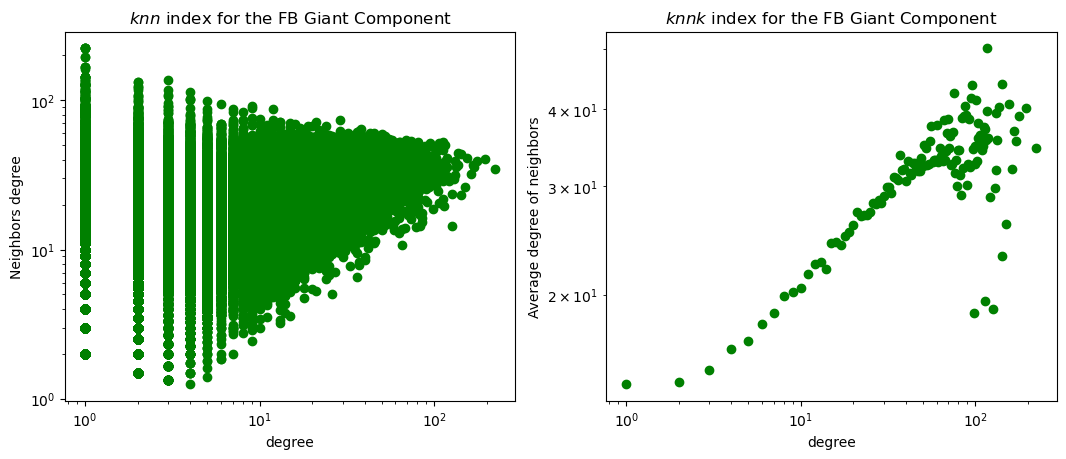

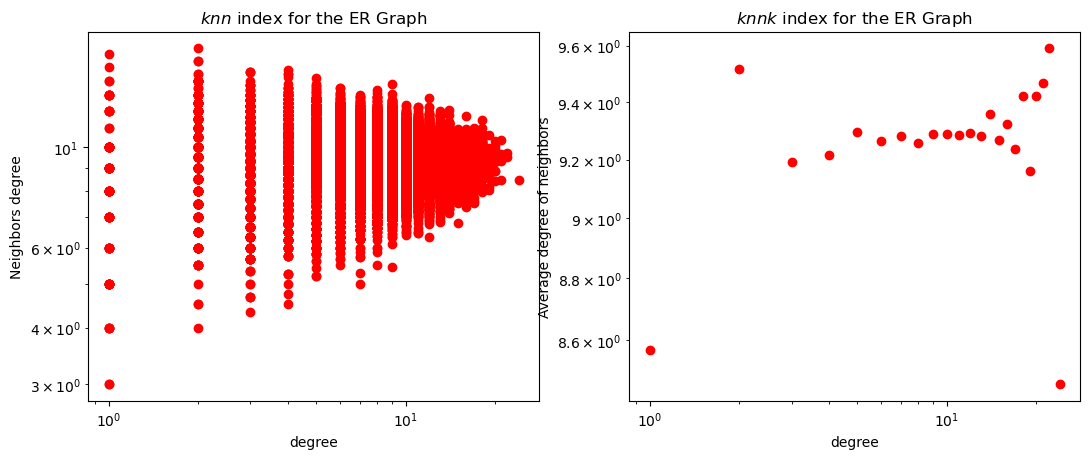

In [31]:
# The global assortativity coefficient - we will need the undirected version of the graph from now on
fb_GC_u.assortativity_degree()

# The knn data. Two lists are returned
# - the list of average degrees for each node (knn)
# - the list of average degrees for each degree (knnk)
fb_knn, fb_knnk = fb_GC_u.knn()

_ = fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (2*default_sizes[0], default_sizes[1]))
_ = ax1.loglog(fb_GC_u.degree(), fb_knn, 'go')
_ = ax1.set_xlabel("degree")
_ = ax1.set_ylabel("Neighbors degree")
_ = ax1.set_title("$knn$ index for the FB Giant Component")

_ = ax2.loglog(range(1,max(fb_GC_u.degree())+1), fb_knnk, 'go')
_ = ax2.set_xlabel("degree")
_ = ax2.set_ylabel("Average degree of neighbors")
_ = ax2.set_title("$knnk$ index for the FB Giant Component")



# The global assortativity coefficient
er_fb.assortativity_degree()

# The knn data. Two lists are returned
# - the list of average degrees for each node (knn)
# - the list of average degrees for each degree (knnk)
er_knn, er_knnk = er_fb.knn()

_ = fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (2*default_sizes[0], default_sizes[1]))
_ = ax1.loglog(er_fb.degree(), er_knn, 'ro')
_ = ax1.set_xlabel("degree")
_ = ax1.set_ylabel("Neighbors degree")
_ = ax1.set_title("$knn$ index for the ER Graph")

_ = ax2.loglog(range(1,max(er_fb.degree())+1), er_knnk, 'ro')
_ = ax2.set_xlabel("degree")
_ = ax2.set_ylabel("Average degree of neighbors")
_ = ax2.set_title("$knnk$ index for the ER Graph")

### Clustering

In [32]:
# clustering
fb_GC_u.transitivity_undirected()
fb_GC_u.transitivity_avglocal_undirected(mode="zero")

er_fb.transitivity_undirected()
er_fb.transitivity_avglocal_undirected(mode="zero")

0.08509450365234017

0.114947594862054

0.00014741770008466556

0.0001426648835820866

### Shortest Path

In [33]:
# Shortest path lenght
# on a subset of the nodes, as otherwise it will take forever to compute
fb_vs_src = sample(list(fb_GC_u.vs), 1000)
fb_vs_trg = sample(list(fb_GC_u.vs), 1000)
er_vs_src = sample(list(er_fb.vs), 1000)
er_vs_trg = sample(list(er_fb.vs), 1000)

fb_sp = mean(np.array(fb_GC_u.distances(fb_vs_src, fb_vs_trg, weights=None)).flatten())
fb_sp
fb_GC_u.vcount()
mean(np.array(er_fb.distances(er_vs_src, er_vs_trg)).flatten())
er_fb.vcount()

5.566717999999916

43953

5.300197000000225

43939

## Power Law Graph

### Assortativity

0.21597845991008502

-0.0009135193534809158

-0.004401152620645054

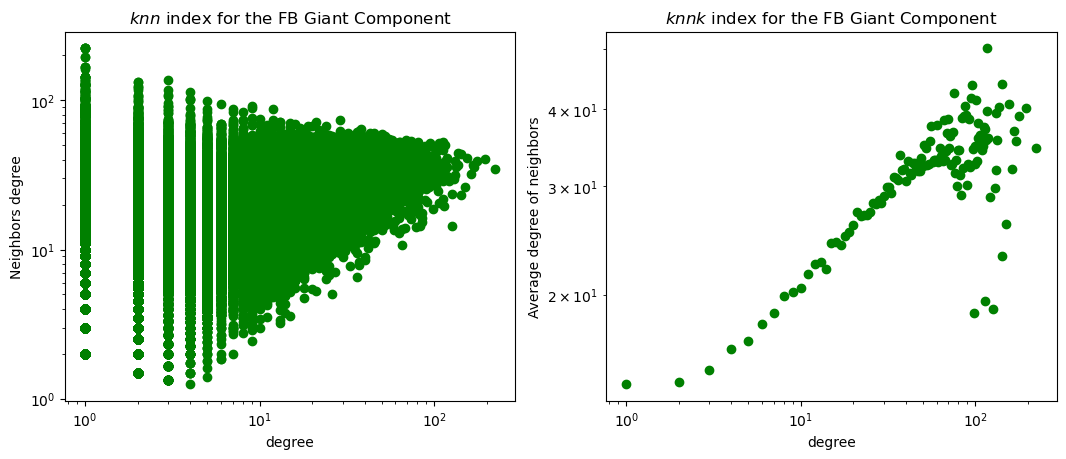

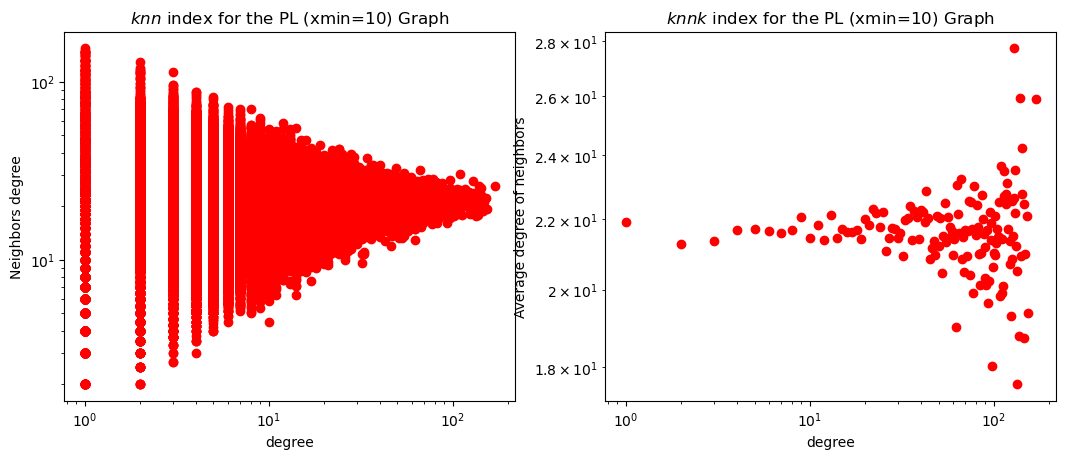

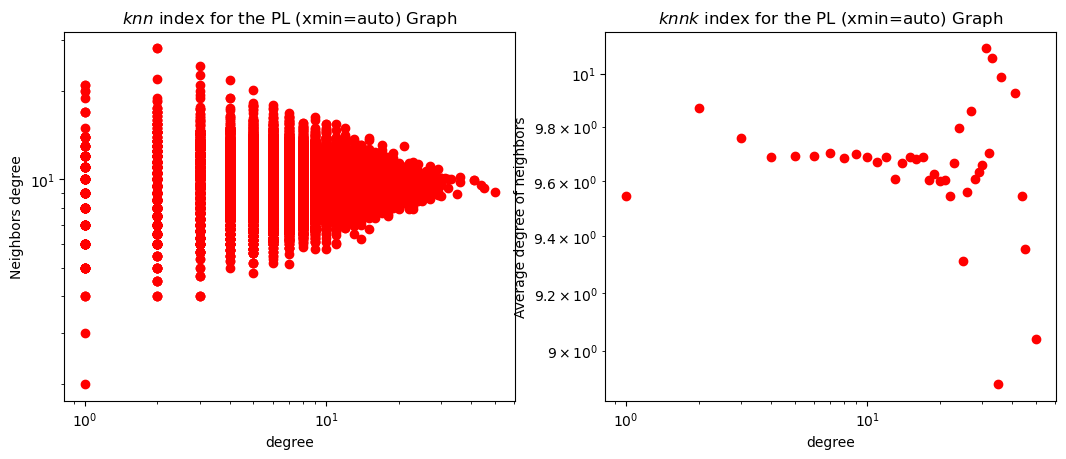

In [34]:
# The global assortativity coefficient - we will need the undirected version of the graph from now on
fb_GC_u.assortativity_degree()

# The knn data. Two lists are returned
# - the list of average degrees for each node (knn)
# - the list of average degrees for each degree (knnk)
fb_knn, fb_knnk = fb_GC_u.knn()

_ = fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (2*default_sizes[0], default_sizes[1]))
_ = ax1.loglog(fb_GC_u.degree(), fb_knn, 'go')
_ = ax1.set_xlabel("degree")
_ = ax1.set_ylabel("Neighbors degree")
_ = ax1.set_title("$knn$ index for the FB Giant Component")

_ = ax2.loglog(range(1,max(fb_GC_u.degree())+1), fb_knnk, 'go')
_ = ax2.set_xlabel("degree")
_ = ax2.set_ylabel("Average degree of neighbors")
_ = ax2.set_title("$knnk$ index for the FB Giant Component")


# PL graph with xmin = 10
# The global assortativity coefficient
pl_fb.assortativity_degree()

# The knn data. Two lists are returned
# - the list of average degrees for each node (knn)
# - the list of average degrees for each degree (knnk)
pl_knn, pl_knnk = pl_fb.knn()

_ = fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (2*default_sizes[0], default_sizes[1]))
_ = ax1.loglog(pl_fb.degree(), pl_knn, 'ro')
_ = ax1.set_xlabel("degree")
_ = ax1.set_ylabel("Neighbors degree")
_ = ax1.set_title("$knn$ index for the PL (xmin=10) Graph")

_ = ax2.loglog(range(1,max(pl_fb.degree())+1), pl_knnk, 'ro')
_ = ax2.set_xlabel("degree")
_ = ax2.set_ylabel("Average degree of neighbors")
_ = ax2.set_title("$knnk$ index for the PL (xmin=10) Graph")



# PL graph with xmin = auto
# The global assortativity coefficient
pl_fb_auto.assortativity_degree()

# The knn data. Two lists are returned
# - the list of average degrees for each node (knn)
# - the list of average degrees for each degree (knnk)
pl_a_knn, pl_a_knnk = pl_fb_auto.knn()

_ = fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (2*default_sizes[0], default_sizes[1]))
_ = ax1.loglog(pl_fb_auto.degree(), pl_a_knn, 'ro')
_ = ax1.set_xlabel("degree")
_ = ax1.set_ylabel("Neighbors degree")
_ = ax1.set_title("$knn$ index for the PL (xmin=auto) Graph")

_ = ax2.loglog(range(1,max(pl_fb_auto.degree())+1), pl_a_knnk, 'ro')
_ = ax2.set_xlabel("degree")
_ = ax2.set_ylabel("Average degree of neighbors")
_ = ax2.set_title("$knnk$ index for the PL (xmin=auto) Graph")

### Clustering

In [35]:
# clustering coefficients
cc_pl = pl_fb.transitivity_undirected()
cc_pl_auto = pl_fb_auto.transitivity_undirected()
cc_fb = fb_GC_u.transitivity_undirected()
print ("Clustering: (FB) %.5f; (PL xmin=%d) %.5f; (PL auto xmin) %.5f" %(cc_fb, xmin, cc_pl, cc_pl_auto))

Clustering: (FB) 0.08509; (PL xmin=10) 0.00119; (PL auto xmin) 0.00020


### Shortest Path

In [36]:
# Shortest path lenght
# on a subset of the nodes, as otherwise it will take forever to compute
pl_vs_src = sample(list(pl_fb.vs), 500)
pl_vs_trg = sample(list(pl_fb.vs), 500)

pl_auto_vs_src = sample(list(pl_fb_auto.vs), 500)
pl_auto_vs_trg = sample(list(pl_fb_auto.vs), 500)

sp_pl = mean(np.array(pl_fb.distances(pl_vs_src, pl_vs_trg)).flatten())
sp_pl_auto = mean(np.array(pl_fb_auto.distances(pl_auto_vs_src, pl_auto_vs_trg)).flatten())
print ("Shortest paths: (FB) %.2f; (PL xmin=%d) %.2f; (PL auto xmin) %.2f" % (fb_sp, xmin, sp_pl, sp_pl_auto))

Shortest paths: (FB) 5.57; (PL xmin=10) 4.49; (PL auto xmin) 5.25


# Part 8. Manipulating graphs

__Vertex, Edge, VertexSeq and EdgeSeq__

In [37]:
# Vertex Sequence of the graph method vs()
fg_vs = fg.vs()

# the attributes of the vertices
fg_vs.attributes()

# VertexSeq can be accessed as arrays, e.g., the 11-th vertices in the sequence is
fg_vs[10]

# VertexSeq can also be accessed as dictionaries, e.g., the names of the first ten nodes
# Note:
#  - fg_vs["name"] is a list with all names of all vertices, from which we only pick the first 10 entries
fg_vs["name"][0:9]

['name']

igraph.Vertex(<igraph.Graph object at 0x148059440>, 10, {'name': '5875'})

['2', '3', '79', '872', '1043', '1847', '3306', '3372', '4605']

In [38]:
# One specific vertex (a Vertex object)
vert = fg_vs[0]
vert

# Attributes of the vertex, as a dict object
vert.attributes()

# So, attributes can be accessed as dictionaries of a Vertex object
vert["name"]

# The index of the vertex and the graph it belongs to
vert.index
vert.graph

# VertexSeq can be indexed
names = [v["name"] for v in fg_vs]
names[0:9]

igraph.Vertex(<igraph.Graph object at 0x148059440>, 0, {'name': '2'})

{'name': '2'}

'2'

0

['2', '3', '79', '872', '1043', '1847', '3306', '3372', '4605']

__Note__

  - Node with ID 0 has name "2", i.e., don't mess up between indices and names of vertices 

### Edge Sequences
Very similar to Vertex sequences

In [39]:
# Edge Sequence of the graph method es()
fg_es = fg.es()

# the attributes of the edges
fg_es.attributes()

# EdgeSeq can be accessed as arrays, e.g., the fisrt edge in the sequence is
fg_es[0]

# EdgeSeq can also be accessed as dictionaries, e.g., the names of the first ten nodes
# Note:
#  - fg_es["weight"] is a list with all weights of all edges, from which we only pick the first 10 entries
fg_es["weight"][0:9]

['weight']

igraph.Edge(<igraph.Graph object at 0x148059440>, 0, {'weight': 13.0})

[13.0, 1.0, 1.0, 1.0, 8.0, 11.0, 3.0, 1.0, 4.0]

In [40]:
# One specific edge (an Edge object)
edge = fg_es[0]
edge

# Attributes of the edge, as a dict object
edge.attributes()

# So, attributes can be accessed as dictionaries of a Vertex object
edge["weight"]

# The index of the vertex and the graph it belongs to
edge.index
edge.graph

# The IDs of the vertices forming the edge
edge.tuple
edge.source
edge.target

# The names of the vertices forming the edge
fg_vs[edge.source]["name"]
fg_vs[edge.target]["name"]

# EdgeSeq can be indexed
weights = [e["weight"] for e in fg_es]
weights[0:9]

igraph.Edge(<igraph.Graph object at 0x148059440>, 0, {'weight': 13.0})

{'weight': 13.0}

13.0

0

(0, 1)

0

1

'2'

'3'

[13.0, 1.0, 1.0, 1.0, 8.0, 11.0, 3.0, 1.0, 4.0]

### Select methods
select a subset of elements from a Sequence object (either Vertex of Edges), based on properties of the elements of the set

In [41]:
# select based on attributes
vs_sel_name = fg_vs.select(name_eq = "2")
vs_sel_name[0]

# select based on callable object
def index5(v):
    if v.index < 5:
        return True
    else:
        return False
    
vs_sel_index = fg_vs.select(index5)
vs_sel_index["name"]

# select based on iterables
indices = [1, 2, 3]
vs_sel_iter = fg_vs.select(indices)
vs_sel_iter["name"]

# find() only finds the first object matching the condition
# NB: when no operator is given explictly, igraph assumes that "name" is used
#     therefore, the following is equivalent to find(name_eq = "2")
vs_find_name = fg.vs.find("2")
vs_find_name["name"]
vs_find_name.index

igraph.Vertex(<igraph.Graph object at 0x148059440>, 0, {'name': '2'})

['2', '3', '79', '872', '1043']

['3', '79', '872']

'2'

0

__Notes__

Select based on attributes

  - syntax: attr_op = value
    - attr is the name of an attribute of vertices
    - op is an operator (such as eq, gt, le, in, notin)
    - __NB__: attr_gt = 2 selects vertices for which the value of attr is greater than 2
    
Select based on callable object
  - the first argument must be a function, which is invoked for any vertex in the set
     - if it returns True, the vertex is included
  - __NB__: to be meaningful, the function must take the vertex as parameter
  
Select based on iterables

  - the first argument must be an iterable object (i.e., a list)
     - it __must__ return integers, which are used as indices of the elements to select in the sequence

## Manipulating graphs

Vertices and edges can be added/removed.

We use a small toy graph as example, stored in NCOL format in $\tt{./toy\_graph.ncol}$

In [42]:
toy_g = read("./toy_graph.ncol", format = "ncol", directed = True)
summary(toy_g, verbosity = 1, edge_list_format = "edgelist")

IGRAPH DNW- 5 6 -- 
+ attr: name (v), weight (e)
+ edges (vertex names):
      edge   weight
[0]   1->2    0.100
[1]   1->3    0.300
[2]   1->4    0.010
[3]   1->5    0.500
[4]   2->5        1
[5]   3->4    0.900


### Adding/removing Vertices

In [43]:
# Add two vertices whose names are "6" and "7"
toy_g.add_vertices(["6","7"])
toy_g.vs["name"]
toy_g.vs.select(name_eq = "6")[0].index

['1', '2', '3', '4', '5', '6', '7']

5

__Notes__

Multiple nodes with the same name can exist (igraph identifies vertices by __IDs__)

In [44]:
toy_g.add_vertices(["6","7"])
toy_g.vs["name"]

['1', '2', '3', '4', '5', '6', '7', '6', '7']

In [45]:
# remove vertices
toy_g.delete_vertices(["6","7"])
toy_g.vs["name"]

['1', '2', '3', '4', '5', '6', '7']

In [46]:
# remove vertices by index
toy_g.delete_vertices([5,6])
toy_g.vs["name"]

['1', '2', '3', '4', '5']

In [47]:
# vertices can be added/delected also by using a Vertex Sequence
toy_g.add_vertices(["6","7"])
toy_g.vs["name"]

to_delete = toy_g.vs.select(index5)
toy_g.delete_vertices(to_delete)
toy_g.vs["name"]

['1', '2', '3', '4', '5', '6', '7']

['6', '7']

### Adding Edges

In [48]:
toy_g = read("./toy_graph.ncol", format = "ncol", directed = True)
summary(toy_g, verbosity = 1, edge_list_format = "edgelist")

# Add:
# - two vertices, with name "a" and "b"
# - weighted links between them
# - a link from "5" to "a"
# - see http://igraph.org/python/doc/igraph.Graph-class.html#add_edge
toy_g.add_vertices(["a","b"])
toy_g.add_edge("a","b",weight = 0.02)
toy_g.add_edge("b","a",weight = 0.01)
toy_g.add_edge("5","a",weight = 0.03)
summary(toy_g, verbosity = 1, edge_list_format = "edgelist")

IGRAPH DNW- 5 6 -- 
+ attr: name (v), weight (e)
+ edges (vertex names):
      edge   weight
[0]   1->2    0.100
[1]   1->3    0.300
[2]   1->4    0.010
[3]   1->5    0.500
[4]   2->5        1
[5]   3->4    0.900


igraph.Edge(<igraph.Graph object at 0x14ad22440>, 6, {'weight': 0.02})

igraph.Edge(<igraph.Graph object at 0x14ad22440>, 7, {'weight': 0.01})

igraph.Edge(<igraph.Graph object at 0x14ad22440>, 8, {'weight': 0.03})

IGRAPH DNW- 7 9 -- 
+ attr: name (v), weight (e)
+ edges (vertex names):
      edge   weight
[0]   1->2    0.100
[1]   1->3    0.300
[2]   1->4    0.010
[3]   1->5    0.500
[4]   2->5        1
[5]   3->4    0.900
[6]   a->b    0.020
[7]   b->a    0.010
[8]   5->a    0.030


### Removing Edges

In [49]:
# see http://igraph.org/python/doc/igraph.Graph-class.html#delete_edges

# We want to remove edges between nodes "a" and "b"

# First way: use edges IDs
#   - edges IDs as a list
def first_way():
    edge_ids = toy_g.get_eids([("a","b"),("b","a")])
    toy_g.delete_edges(edge_ids)

# Second way: delete edges by the names of the vertices
#   - set of edges as list of tuples
def second_way():
    toy_g.delete_edges([("a","b"), ("b","a")])
    
# Third way: delete edges by the IDs of the vertices
def third_way():
    id1 = toy_g.vs.select(name_eq = "a")[0].index
    id2 = toy_g.vs.select(name_eq = "b")[0].index
    toy_g.delete_edges([(id1,id2), (id2, id1)])
    
# Fourth_way: delete an EdgeSeq
def fourth_way():
    id1 = toy_g.vs.select(name_eq = "a")[0].index
    id2 = toy_g.vs.select(name_eq = "b")[0].index
    del_edges = toy_g.es.select(_between = ([id1],[id2]))
    toy_g.delete_edges(del_edges)
    

# emulate a switch
cases = {
    'first'   : first_way,
    'second'  : second_way,
    'third'   : third_way,
    'fourth'  : fourth_way
}

my_case = cases['first']
my_case()

# check the result
summary(toy_g, verbosity=1, edge_list_format = "edgelist")

# put the deleted edges back
toy_g.add_edge("a","b",weight = 0.02)
toy_g.add_edge("b","a",weight = 0.01)
summary(toy_g, verbosity=1, edge_list_format = "edgelist")

IGRAPH DNW- 7 7 -- 
+ attr: name (v), weight (e)
+ edges (vertex names):
      edge   weight
[0]   1->2    0.100
[1]   1->3    0.300
[2]   1->4    0.010
[3]   1->5    0.500
[4]   2->5        1
[5]   3->4    0.900
[6]   5->a    0.030


igraph.Edge(<igraph.Graph object at 0x14ad22440>, 7, {'weight': 0.02})

igraph.Edge(<igraph.Graph object at 0x14ad22440>, 8, {'weight': 0.01})

IGRAPH DNW- 7 9 -- 
+ attr: name (v), weight (e)
+ edges (vertex names):
      edge   weight
[0]   1->2    0.100
[1]   1->3    0.300
[2]   1->4    0.010
[3]   1->5    0.500
[4]   2->5        1
[5]   3->4    0.900
[6]   5->a    0.030
[7]   a->b    0.020
[8]   b->a    0.010


__Notes__

- in the fourth case, the $\tt{\_between}$ argument uses two sets of vertices __IDs__ (not names) and returns the set of edges existing between any element in the first set and any element in the second
- when edges (or vertices) are removed, the __IDs are recomputed__
    - note that edge "5->a" moves from index [8] to index [6] after deleting the edges, no matter what method we use
    - beware when deleting edges by their IDs (IDs of an edge can change dynamically)

### Creating, deleting, setting attributes

In [50]:
# Adding an attribute to nodes
toy_g.vs["color"] = 'red'

# Setting the attribute of a specific node
id = toy_g.vs.find(name_eq = 'a').index
toy_g.vs[id]["color"] = 'blue'

summary(toy_g, verbosity=1, edge_list_format = "edgelist", print_vertex_attributes = True)

# deleting attributes
# - vertices seen as a dictionary
del toy_g.vs["color"]

IGRAPH DNW- 7 9 -- 
+ attr: color (v), name (v), weight (e)
+ vertex attributes:
      color   name
[0]   red     1   
[1]   red     2   
[2]   red     3   
[3]   red     4   
[4]   red     5   
[5]   blue    a   
[6]   red     b   
+ edges (vertex names):
      edge   weight
[0]   1->2    0.100
[1]   1->3    0.300
[2]   1->4    0.010
[3]   1->5    0.500
[4]   2->5        1
[5]   3->4    0.900
[6]   5->a    0.030
[7]   a->b    0.020
[8]   b->a    0.010


Setting __edge__ attributes

- edges have a new attribute called $\tt{type}$
- set the values in two classes
    - all are of $\tt{type\_B}$
    - but those between vertices with __names__ $\tt{1,2}$ and $\tt{3,4}$, which are of $\tt{type\_A}$

In [51]:
# All of type_B
toy_g.es["type"] = 'type_B'

# Vertex set with indices of the first group
vs1 = toy_g.vs.select(name_in = ["1","2"])
# Vertex set with indices of the second group
vs2 = toy_g.vs.select(name_in = ["3","4"])
# Edges between nodes in the two sets
es = toy_g.es.select(_between = (vs1, vs2))
# Set the attribute for those edges
es["type"] = 'type_A'

summary(toy_g, verbosity=1, edge_list_format = "edgelist")

IGRAPH DNW- 7 9 -- 
+ attr: name (v), type (e), weight (e)
+ edges (vertex names):
      edge    type    weight
[0]   1->2   type_B    0.100
[1]   1->3   type_A    0.300
[2]   1->4   type_A    0.010
[3]   1->5   type_B    0.500
[4]   2->5   type_B        1
[5]   3->4   type_B    0.900
[6]   5->a   type_B    0.030
[7]   a->b   type_B    0.020
[8]   b->a   type_B    0.010


## Graph with a given degree sequence

In [52]:
deg_seq = fb_GC_u.degree()
# in general the parameter deg_seq needs to be a list with a degree sequence, i.e.
# - one element per node
# - the element is the degree of the node
fb_DS = Graph.Degree_Sequence(deg_seq, method="vl")

In [53]:
# in this case we have just re-created the fb_GC_u graph
fb_DS.vcount()
fb_DS.ecount()
fb_GC_u.vcount()
fb_GC_u.ecount()
mean(fb_DS.degree())
mean(fb_GC_u.degree())

43953

182384

43953

182384

8.29904670898459

8.29904670898459